## Dogs VS Cats

This notebook will describe how to solve kaggle challenge [Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)

### Problem Description
Dogs vs. Cats is an image recognition problem, where given an image of either dogs or cats, predict is it a picture of a cat or a dog

### Data
* Training set containing 12500 dog pictures and 12500 cat pictures
* Test set containing 12500 pictures to be predicted

### Solution
To solve this problem, I use pretrained model, in this case [VGG](https://arxiv.org/abs/1409.1556). I choose [Keras implementation of VGG](https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3).

Pretrained model is an already available model that has be trained on similar problem. VGG is used because 
1. VGG wins ImageNet 2014, a Image Recognition annual competition. 
2. The behaviour of ImageNet data can is similar to our problem.
3. VGG is the last pretrained model that is simple and powerful.

We can't use VGG model directly because our task is to predict dog or cat, not the 1000 category that is used in ImageNet. 

Below are the detail steps to solve this problem:
1. [Create VGG Class Instance](#step1)
2. [Create input data batches for training](#step2)
3. [Finetune model to output only dog or cat](#step3)
4. [Predict unlabeled images](#step4)
5. [Create submission for kaggle](#step5)

This line will make our plot will be showed in the notebook.

In [1]:
%matplotlib inline

Define path to our data, this path contains train and valid folders, in each folder there are dog folder and cat folder

In [2]:
path = 'data/dogscats/sample/'
# path = 'data/dogscats/'

training_epoch = 1

Import libraries that we will use

In [3]:
import numpy as np
import pandas as pd
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

import utils; reload(utils)
from utils import plots
import vgg16; reload(vgg16)
from vgg16 import Vgg16
from keras.preprocessing import image

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Using TensorFlow backend.


#### <a id='step1'>Create VGG Class Instance</a>

In [4]:
vgg = Vgg16()

#### <a id='step2'>Create input data batches for training</a>

In [5]:
def generate_batches(batch_size):
    batches = vgg.get_batches(path + 'train', batch_size=batch_size)
    val_batches = vgg.get_batches(path + 'valid', batch_size=batch_size)
    return batches, val_batches

def generate_text_label(labels):
    return ['cat' if label[0] else 'dog' for label in labels]

`generate_batches` function will return python generator, you can see the value of one batch below

Found 16 images belonging to 2 classes.
Found 8 images belonging to 2 classes.


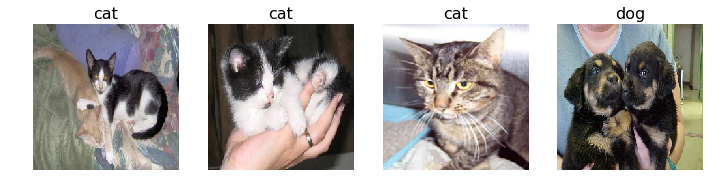

In [6]:
batches, val_batches = generate_batches(4) # Using batch_size = 4

imgs, labels = next(batches)
plots(imgs, titles=generate_text_label(labels))

We can predict the images above using raw VGG model, this will result in category used in ImageNet

In [7]:
vgg.predict(imgs, True)

(array([ 0.1573,  0.3318,  0.5232,  0.2458], dtype=float32),
 array([362, 377, 281, 158]),
 [u'badger', u'marmoset', u'tabby', u'toy_terrier'])

The result above return 3 array, the first array is the probability of each predicted class, the second array is the index of the class of ImageNet category, the third array is the name of the class of ImageNet Category.

#### <a id='step3'>Finetune model to output only dog or cat</a>

In [8]:
batches, val_batches = generate_batches(4) # Using batch_size = 64
vgg.finetune(batches)

Found 16 images belonging to 2 classes.
Found 8 images belonging to 2 classes.


#### <a id='step4'>Fit the training data</a>

In [9]:
vgg.fit(batches, val_batches, nb_epoch=training_epoch)

Epoch 1/1
16/16 [==============================] - 57s - loss: 0.8920 - acc: 0.5625 - val_loss: 1.4580 - val_acc: 0.5000


#### <a id='step4'>Predict unlabeled images</a>

Found 16 images belonging to 2 classes.
Found 8 images belonging to 2 classes.


(array([ 0.9845,  0.9354,  0.8065,  0.7654], dtype=float32),
 array([0, 0, 1, 0]),
 ['cats', 'cats', 'dogs', 'cats'])

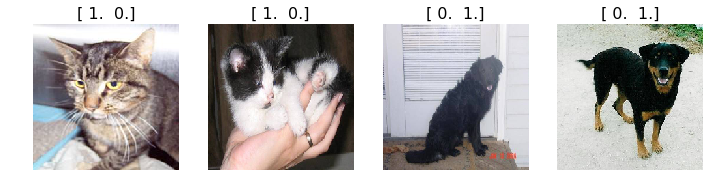

In [10]:
batches, val_batches = generate_batches(4) # Using batch_size = 4
imgs, labels = next(batches)
plots(imgs, titles=labels)
vgg.predict(imgs, True)

#### <a id='step5'>Create submission for kaggle</a>

We now load kaggle test data. We first declare a path to a directory that containing our images. We also set batch_size of images.

In [11]:
# Containing folder to predict the cass

kaggle_test_dir = 'test1'
batch_size = 4

We then predict each images.

In [12]:
test_batches, predictions = vgg.test(path+kaggle_test_dir, batch_size=batch_size)

Found 10 images belonging to 1 classes.


We now create submission files.

Submission files contains 2 columns. First column is <b>id</b>, the name of the file. Second column is <b>label</b>, the probability that the image is a dog.

To measure model performance, kaggle use log loss function.


First, we create a function to create a proper id of the image.

In [13]:
def get_proper_image_name(full_img_filename):
    return full_img_filename[5:][:-4]

We then create a function to output a submission file.

In [14]:
def create_kaggle_submission(output_file, test_batches, predictions):
    ids = [get_proper_image_name(filename) for filename in test_batches.filenames]
    labels = [pred[1] for pred in predictions] # cat = 0, dog = 1
    df_result = pd.DataFrame(
        {
            'id': ids,
            'label': labels
        }
    )
    df_result.to_csv(output_file, index=False)

In [15]:
submission_filename = path + 'submission.csv'
create_kaggle_submission(submission_filename,test_batches, predictions)